# **Decision Tree**

## Inspecting the dataset

In [1]:
import pandas as pd

file_path = "final_cleaned_oscars.csv"
df = pd.read_csv(file_path)

df.head()

,Year,Category,Film,Film_ID,Nominee,Winner,TMDb_ID,Popularity,Vote_Count,Vote_Average,Genres,Director,IMDb_Rating
0,1972,Best Cinematography,1776,tt0068156,"Harry Stradling, Jr.",False,14902,6.822,75,6.8,"Drama, History, Musical",Peter H. Hunt,7.2
1,2019,Best Cinematography,1917,tt8579674,Roger Deakins,True,530915,45.996,12542,8.0,"Action, Drama, War",Sam Mendes,8.2
2,2019,Best Director,1917,tt8579674,Sam Mendes,False,530915,45.996,12542,8.0,"Action, Drama, War",Sam Mendes,8.2
3,2019,Best Picture,1917,tt8579674,"Sam Mendes, Pippa Harris, Jayne-Ann Tenggren a...",False,530915,45.996,12542,8.0,"Action, Drama, War",Sam Mendes,8.2
4,2019,Best Original Screenplay,1917,tt8579674,Written by Sam Mendes & Krysty Wilson-Cairns,False,530915,45.996,12542,8.0,"Action, Drama, War",Sam Mendes,8.2


## Feature Selection and One-Hot Encoding Categorical Column

In [2]:
df = df[['IMDb_Rating', 'Popularity', 'Vote_Count', 'Vote_Average', 'Category', 'Winner']]

df['Winner'] = df['Winner'].astype(int)

<ipython-input-2-7297d098d918>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Winner'] = df['Winner'].astype(int)


In [3]:
df_encoded = pd.get_dummies(df, columns=['Category'])

df_encoded.to_csv('dt_encoded.csv', index=False)

## Splitting data into Training and Testing sets

In [4]:
X = df_encoded.drop('Winner', axis=1)
y = df_encoded['Winner']

## Train-Test Split (Disjoint Sets)

In [5]:
from sklearn.model_selection import train_test_split

# Use stratify=y to maintain class balance in split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Saving the datasets

In [6]:
train_data = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
test_data = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)

train_data.to_csv('dt_train_data.csv', index=False)
test_data.to_csv('dt_test_data.csv', index=False)

## Balancing the Training Data Using SMOTE

In [7]:
!pip install imbalanced-learn

In [8]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE only to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [9]:
# Save the balanced training data
df_train_smote = pd.DataFrame(X_train_smote, columns=X.columns)
df_train_smote['Winner'] = y_train_smote
df_train_smote.to_csv('train_data_smote_balanced.csv', index=False)

## Training 3 Decision Trees (Different Roots / Depths)

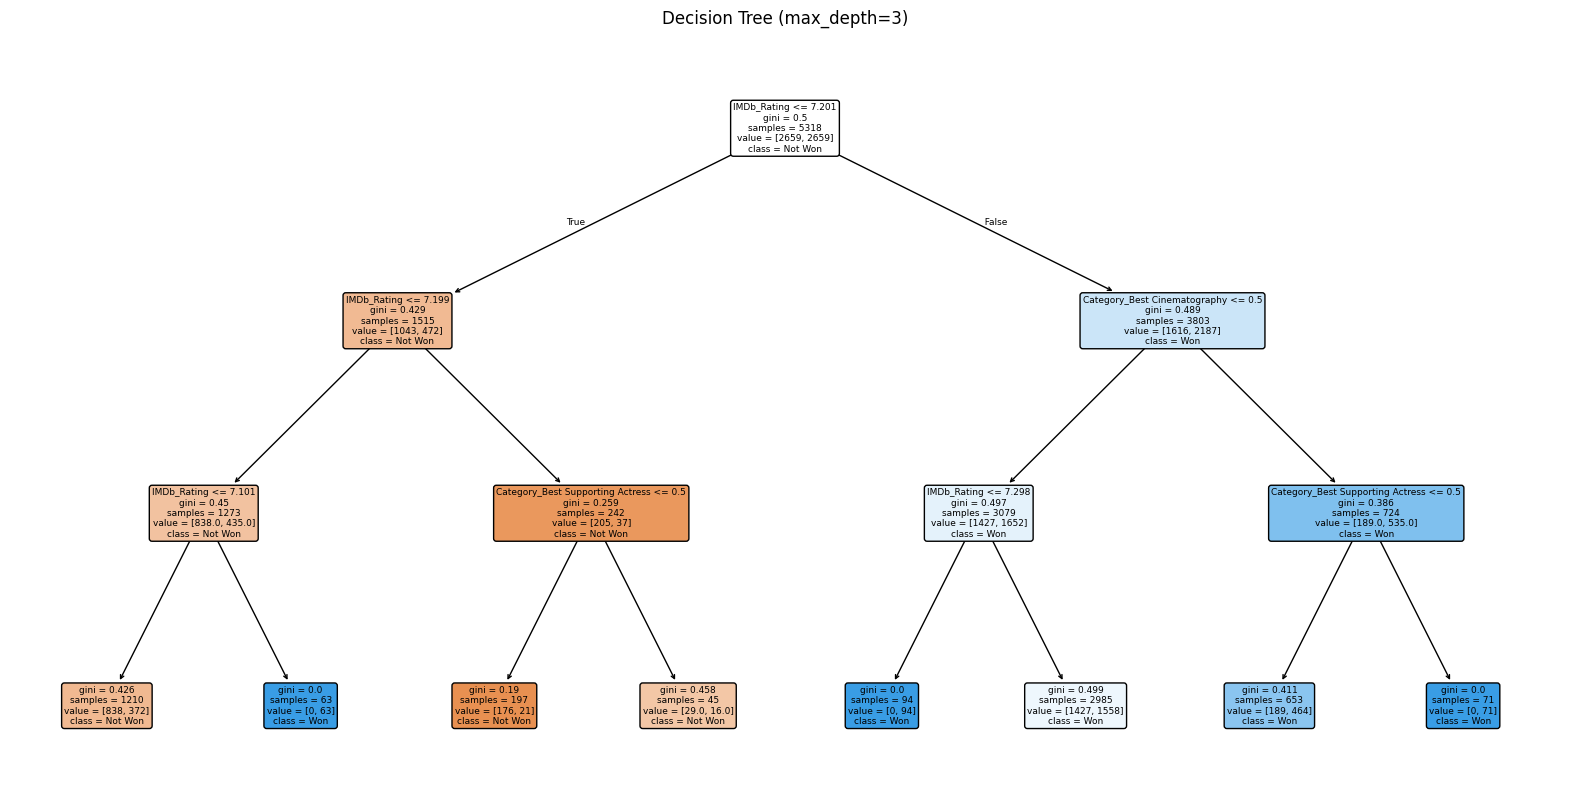

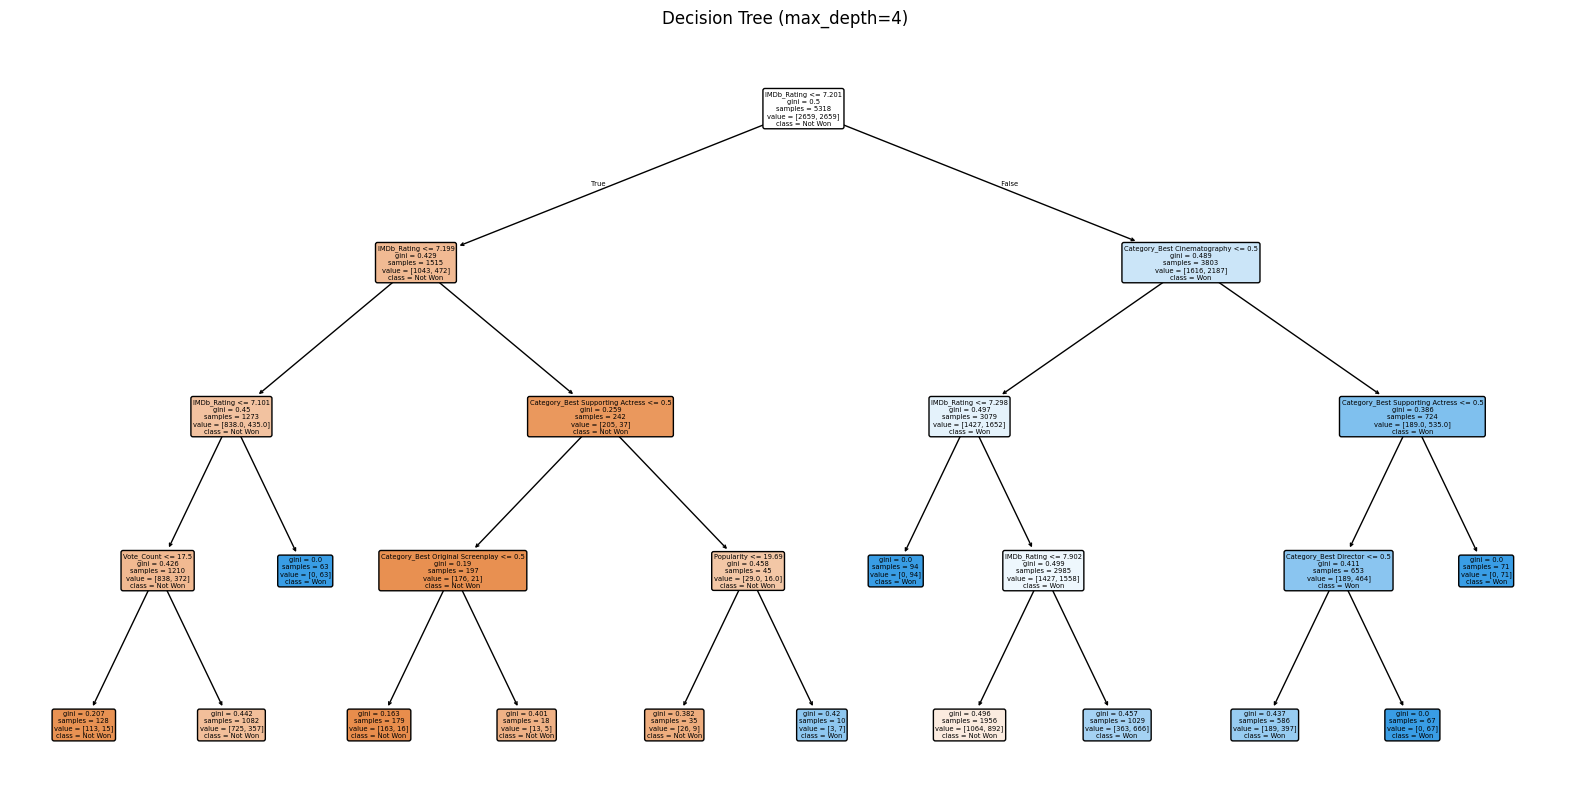

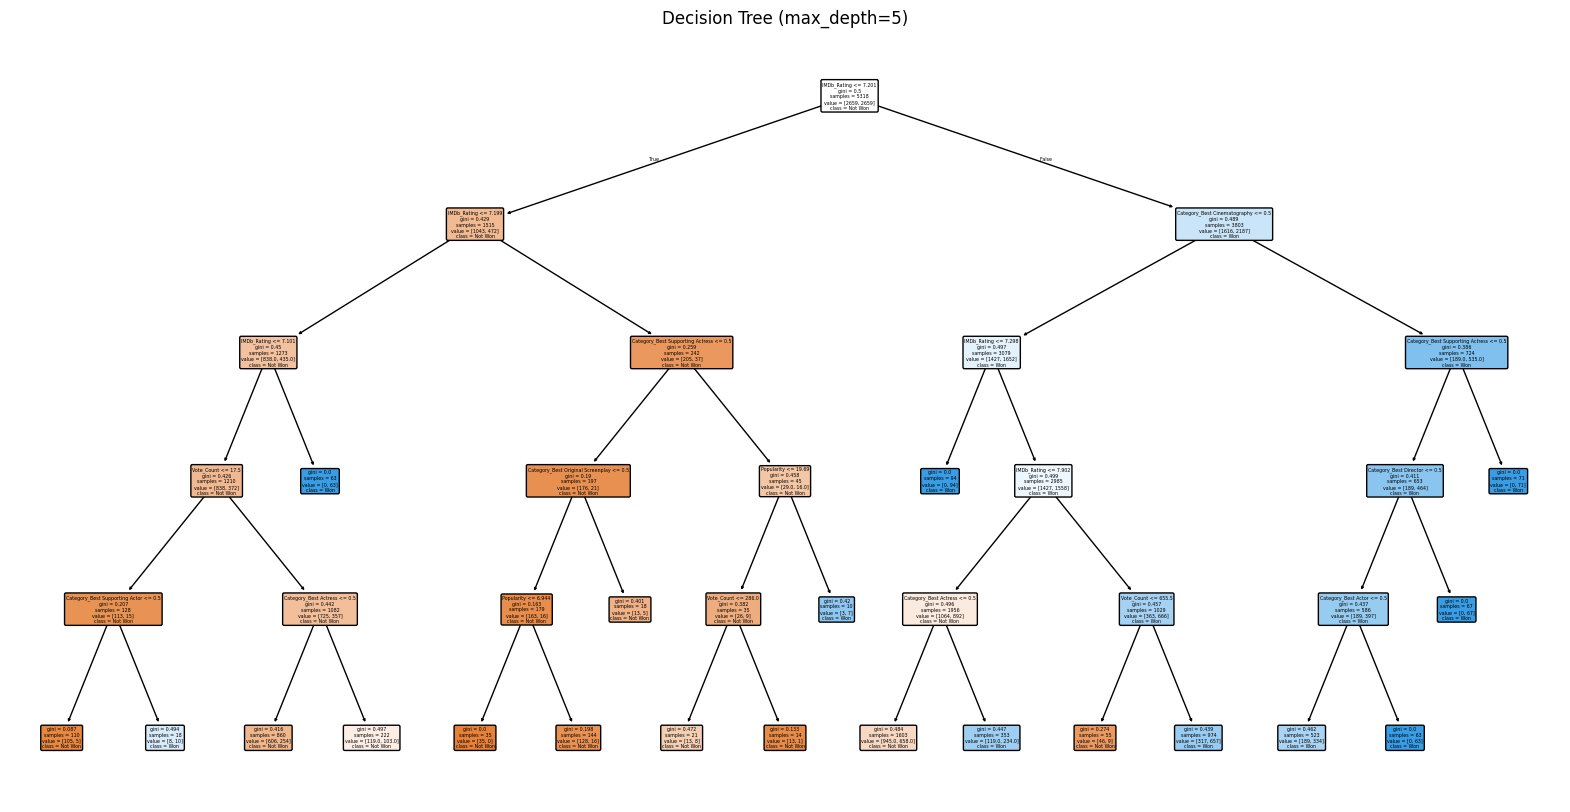

In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Train 3 trees with different depth settings
for depth in [3, 4, 5]:
    clf = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=10, random_state=depth)
    clf.fit(X_train_smote, y_train_smote)

    plt.figure(figsize=(20, 10))
    plot_tree(clf, feature_names=X.columns, class_names=['Not Won', 'Won'], filled=True, rounded=True)
    plt.title(f"Decision Tree (max_depth={depth})")
    plt.show()
    plt.savefig(f'decision_tree_depth_{depth}.png')
    plt.close()

## Evaluating the Final Decision Tree (max_depth = 5)

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Use the last model for evaluation
final_model = DecisionTreeClassifier(max_depth=5, min_samples_leaf=10, random_state=42)
final_model.fit(X_train_smote, y_train_smote)

# Predict on test set
y_pred = final_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print results
print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.6881067961165048

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.75      0.79       665
           1       0.29      0.43      0.35       159

    accuracy                           0.69       824
   macro avg       0.57      0.59      0.57       824
weighted avg       0.74      0.69      0.71       824


Confusion Matrix:
 [[498 167]
 [ 90  69]]


## Visualizing the Confusion Matrix

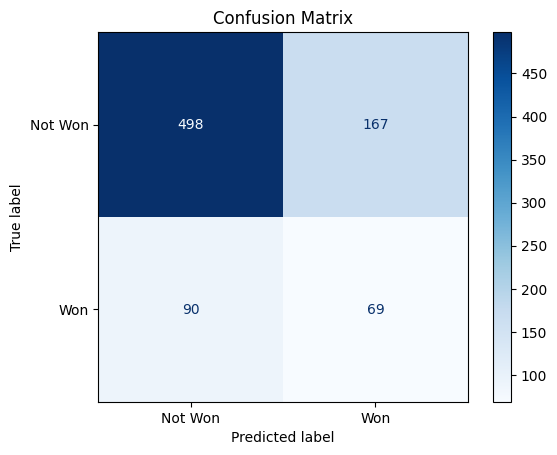

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = final_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Won', 'Won'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()